## Week 6 Homework

In this homework, we'll take the ride duration prediction model that we deployed in batch mode in homework 4 and improve the reliability of our code with unit and integration tests.

You'll find the starter code in the homework directory.

### Q1. Refactoring

Before we can start coverting our code with tests, we need to refactor it. We'll start by getting rid of all the global variables.

   - Let's create a function main with two parameters: year and month.
   - Move all the code (except read_data) inside main
   - Make categorical a parameter for read_data and pass it inside main

Now we need to create the "main" block from which we'll invoke the main function. How does the `if` statement that we use for this looks like?

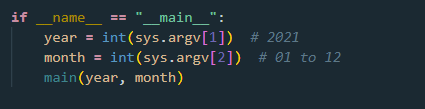

## Q2. Installing pytest

Now we need to install pytest:

```pipenv install --dev pytest```

Next, create a folder tests and create two files. One will be the file with tests. We can name if test_batch.py.

What should be the other file?

Hint: to be able to test batch.py, we need to be able to import it. Without this other file, we won't be able to do it.

## Answer: `__init__.py`

## Q3. Writing first unit test

Now let's cover our code with unit tests.

We'll start with the pre-processing logic inside `read_data`.

It's difficult to test right now because first reads the file and then performs some transformations. We need to split this code into two parts: reading (I/O) and tranformation.

So let's create a function `prepare_data` that takes in a dataframe (and some other parameters too) and applies some tranformation to it.

(That's basically the entire `read_data` function after reading the parquet file)

Now create a test and use this as input:

```
data = [
    (None, None, dt(1, 2), dt(1, 10)),
    (1, 1, dt(1, 2), dt(1, 10)),
    (1, 1, dt(1, 2, 0), dt(1, 2, 50)),
    (1, 1, dt(1, 2, 0), dt(2, 2, 1)),        
]

columns = ['PUlocationID', 'DOlocationID', 'pickup_datetime', 'dropOff_datetime']
df = pd.DataFrame(data, columns=columns)
```

Where `dt` is a helper function:

```
from datetime import datetime

def dt(hour, minute, second=0):
    return datetime(2021, 1, 1, hour, minute, second)
```

Define the expected output and use the assert to make sure that the actual dataframe matches the expected one

Tip: When you compare two Pandas DataFrames, the result is also a DataFrame. The same is true for Pandas Series. Also, a DataFrame could be turned into a list of dictionaries.

How many rows should be there in the expected dataframe?

   - 1
   - 2
   - 3
   - 4

## Answer : 2

## Q4. Mocking S3 with Localstack

Now let's prepare for an integration test. In our script, we write data to S3. So we'll use Localstack to mimic S3.

First, let's run Localstack with Docker compose. Let's create a docker-compose.yaml file with just one service: localstack. Inside localstack, we're only interested in running S3.

Start the service and test it by creating a bucket where we'll keep the output. Let's call it "nyc-duration".

With AWS CLI, this is how we create a bucket:
```    
aws s3 mb s3://nyc-duration
```
Adjust it for localstack. How does the command look like?

## Answer: `aws --endpoint-url=http://localhost:4566 s3 mb s3://nyc-duration`

Check that the bucket was successfully created. With AWS, this is how we typically do it:
```
aws s3 ls
```

`aws --endpoint-url=http://localhost:4566 s3 ls`

## Make input and output paths configurable

Right now the input and output paths are hardcoded, but we want to change it for the tests.

One of the possible ways would be to specify `INPUT_FILE_PATTERN` and `OUTPUT_FILE_PATTERN` via the env variables. Let's do that:
```
export INPUT_FILE_PATTERN="s3://nyc-duration/in/{year:04d}-{month:02d}.parquet"
export OUTPUT_FILE_PATTERN="s3://nyc-duration/out/{year:04d}-{month:02d}.parquet"
```
And this is how we can read them:
```
def get_input_path(year, month):
    default_input_pattern = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/nyc-tlc/fhv/fhv_tripdata_{year:04d}-{month:02d}.parquet'
    input_pattern = os.getenv('INPUT_FILE_PATTERN', default_input_pattern)
    return input_pattern.format(year=year, month=month)


def get_output_path(year, month):
    default_output_pattern = 's3://nyc-duration-prediction-alexey/taxi_type=fhv/year={year:04d}/month={month:02d}/predictions.parquet'
    output_pattern = os.getenv('OUTPUT_FILE_PATTERN', default_output_pattern)
    return output_pattern.format(year=year, month=month)


def main(year, month):
    input_file = get_input_path(year, month)
    output_file = get_output_path(year, month)
    # rest of the main function ... 
```


## Q5. Creating test data

So far we've been reading parquet files from S3 with using pandas `read_parquet`. But this way we read it from the actual S3 service. Now we need to replace it with our localstack one.

For that, we need to specify the endpoint url:
```
options = {
    'client_kwargs': {
        'endpoint_url': S3_ENDPOINT_URL
    }
}

df = pd.read_parquet('s3://bucket/file.parquet', storage_options=options)
```
Now let's create integration_test.py

We'll use the dataframe we created in Q3 (the dataframe for the unit test) and save it to S3. You don't need to do anything else: just create a dataframe and save it.

We will pretent that this is data for January 2021.

Run the `integration_test.py` script. After that, use AWS CLI to verify that the file was created.

What's the size of the file?

   - 3512
   - 33512
   - 63512
   - 93512

## Answer: 3512

## Q6. Finish the integration test

We can read from our localstack s3, but we also need to write to it.

Create a function `save_data` which works similarly to `read_data`, but we use it for saving a dataframe.

Let's run the `batch.py` script for "January 2021" (the fake data we created in Q5).

We can do that from our integration test in Python: we can use `os.system` for doing that (there are other options too).

Now it saves the result to localstack.

The only thing we need to do now is to read this data and verify the result is correct.

What's the sum of predicted durations for the test dataframe?

   - 23.05
   - 46.23
   - 69.28
   - 81.78

## Answer: 69.28